In [177]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox import mdp
from gym.envs.toy_text.frozen_lake import generate_random_map
import re

In [61]:
env = gym.make('FrozenLake-v1')
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    fail = 0
    reward = 0
    done = False
    while not done:
        state, rwd, done, truncated, info = env.step(env.action_space.sample())
        reward = reward + rwd
        counter += 1
    
    if(reward == 0):
        fail +=1
        counter = 0
    return counter, fail

An agent using Random search takes about an average of 13 steps to successfully complete its mission.


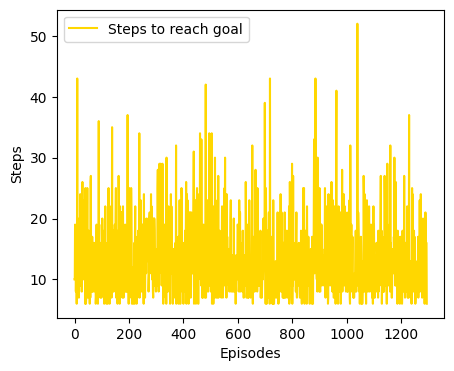

98705


In [63]:
steps = []
fails = []

for i in range(100000):
    step, fail = random_policy_steps_count()

    if(step > 0):
        steps.append(step)

    if(fail > 0):
        fails.append(fail)




print("An agent using Random search takes about an average of " + str(int(np.mean(steps))) + " steps to successfully complete its mission.")
fig, ax = plt.subplots()
ax.plot(steps, color='Gold', label='Steps to reach goal')
ax.set_xlabel('Episodes')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

print(len(fails))

In [65]:
env = gym.make("FrozenLake-v1", map_name="8x8")
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    fail = 0
    reward = 0
    done = False
    while not done:
        state, rwd, done, truncated, info = env.step(env.action_space.sample())
        reward = reward + rwd
        counter += 1
    
    if(reward == 0):
        fail +=1
        counter = 0
    return counter, fail

An agent using Random search takes about an average of 60 steps to successfully complete its mission.


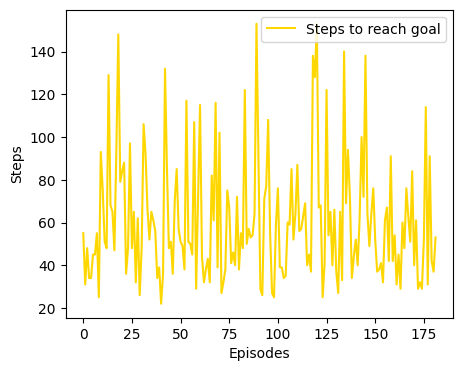

99818


In [66]:
steps = []
fails = []

for i in range(100000):
    step, fail = random_policy_steps_count()

    if(step > 0):
        steps.append(step)

    if(fail > 0):
        fails.append(fail)

print("An agent using Random search takes about an average of " + str(int(np.mean(steps))) + " steps to successfully complete its mission.")
fig, ax = plt.subplots()
ax.plot(steps, color='Gold', label='Steps to reach goal')
ax.set_xlabel('Episodes')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

print(len(fails))

# Using mdptoolbox

# Helper Functions

In [208]:
# From hiivemdptoolbox lib: https://github.com/hiive/hiivemdptoolbox/blob/master/hiive/mdptoolbox/openai.py
class OpenAI_MDPToolbox:
    def __init__(self, openAI_env_name:str, render:bool=False, **kwargs):
        """Create a new instance of the OpenAI_MDPToolbox class
        :param openAI_env_name: Valid name of an Open AI Gym env 
        :type openAI_env_name: str
        :param render: whether to render the Open AI gym env
        :type rander: boolean 
        """
        self.env_name = openAI_env_name
    
        self.env = gym.make(self.env_name, **kwargs)
        self.env.reset()

        if render:
            self.env.render()
        
        self.transitions = self.env.P
        self.actions = int(re.findall(r'\d+', str(self.env.action_space))[0])
        self.states = int(re.findall(r'\d+', str(self.env.observation_space))[0])
        self.P = np.zeros((self.actions, self.states, self.states))
        self.R = np.zeros((self.states, self.actions))
        self.convert_PR()
        
    def convert_PR(self):
        """Converts the transition probabilities provided by env.P to MDPToolbox-compatible P and R arrays
        """
        for state in range(self.states):
            for action in range(self.actions):
                for i in range(len(self.transitions[state][action])):
                    tran_prob = self.transitions[state][action][i][0]
                    state_ = self.transitions[state][action][i][1]
                    self.R[state][action] += tran_prob*self.transitions[state][action][i][2]
                    self.P[action, state, state_] += tran_prob


def plot_policy(run_map, policy, title):
    size = len(run_map)
    map_direction = {0:'←', 1:'↓', 2:'→', 3:'↑'}
    map_convert = {'S':2, 'F':1, 'H':0, 'G':3}
    
    d_map = np.zeros((size, size), dtype='int')
    for i in range(len(run_map)):
        for j in range(len(run_map)):
            d_map[i, j] = map_convert[run_map[i][j]]

    plt.figure()
    plt.imshow(d_map,cmap ="hot")
    plt.title(title)

    for i in range(size):
        for j in range(size):
            if d_map[i, j] in (0, 3):
                continue
            plt.text(j, i, map_direction[policy[size*i+j]], color='w')
    plt.text(size-1, size-1, 'G', color='blue')
    
state_size = '10x10'
random_map =['SFFFFFFFHF',
             'HHFFFHFHFF',
             'FFHFHFFFFF',
             'FFHFFFFHHH',
             'FHFFFHHFFF',
             'FFFFFHFHFF',
             'HFFFFFFFFF',
             'FFFFFFFFFF',
             'FFFFHHFFFF',
             'FHHFFHFFFG']

#env = gym.make('FrozenLake-v1', desc=generate_random_map(size=10))
#env.reset()
#env.P
env = OpenAI_MDPToolbox("FrozenLake-v1", False, desc=random_map, is_slippery=True)
P = env.P
R = env.R



def graph_time(algorithm_model, run_stats):
    plt.figure()
    plt.plot([ i['Time'] for i in run_stats ], marker = '.', color = 'red')
    plt.title(f'Time vs Iteration for {algorithm_model} with world env {state_size}')
    plt.xlabel('Iteration')
    plt.ylabel('Time')
    
def graph_reward(algorithm_model, run_stats):
    plt.figure()
    plt.plot([ i['Reward'] for i in run_stats ], marker = '.', color = 'aqua')
    plt.title(f'Reward vs Iteration for {algorithm_model} with World Env {state_size}')
    plt.xlabel('Iteration')
    plt.ylabel('Reward')

def graph_meanV(algorithm_model, run_stats):
    plt.figure()
    plt.plot([ i['Mean V'] for i in run_stats ], marker = '.', color = 'blue')
    plt.title(f'Mean Value vs Iteration for {algorithm_model} with World Env {state_size}')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Value')

def graph_error(algorithm_model, run_stats):
    plt.figure()
    plt.plot([ i['Error'] for i in run_stats ], marker = '.', color = 'pink')
    plt.title(f'Error vs Iteration for {algorithm_model} with World Env {state_size}')
    plt.xlabel('Iteration')
    plt.ylabel('Error')

# Algorithms Value, Policy and Q-Learning

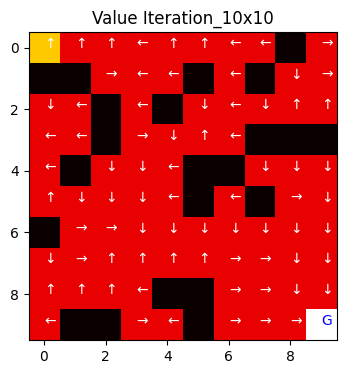

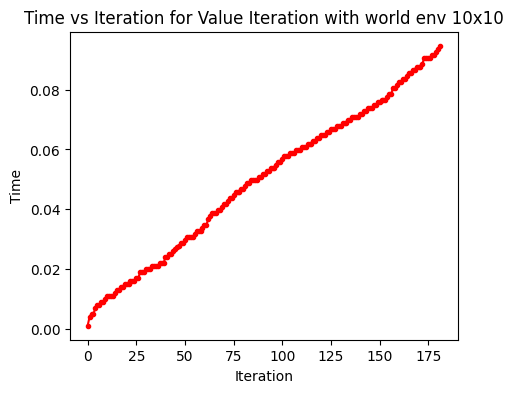

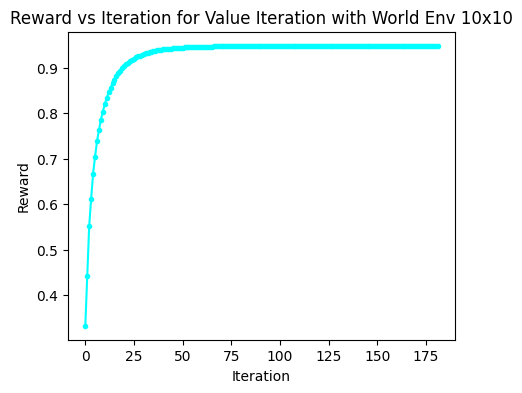

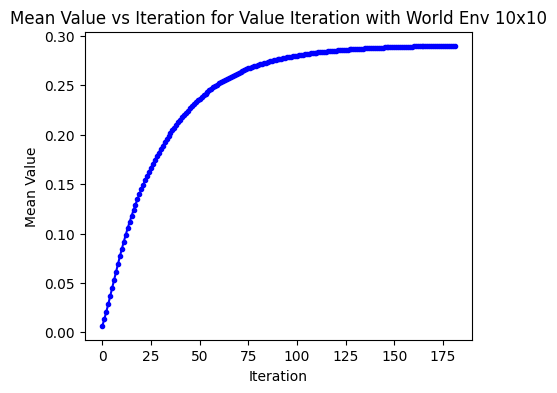

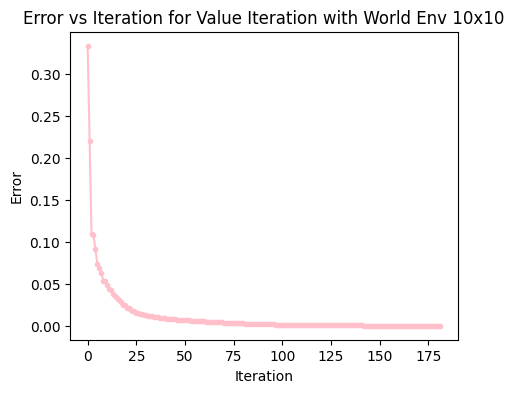

In [209]:
vi = mdp.ValueIteration(P, R, 0.99, max_iter=10000)
vi.run()

plot_policy(random_map, vi.policy, f'Value Iteration_{state_size}')
graph_time("Value Iteration", vi.run_stats)
graph_reward("Value Iteration", vi.run_stats)
graph_meanV("Value Iteration", vi.run_stats)
graph_error("Value Iteration", vi.run_stats)

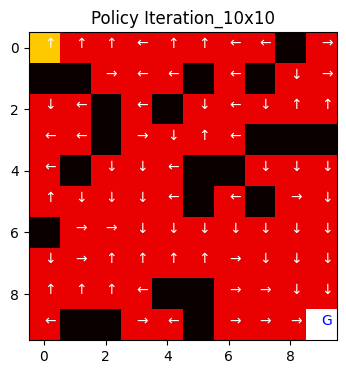

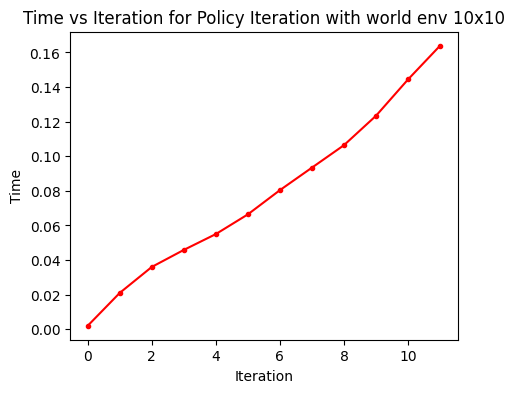

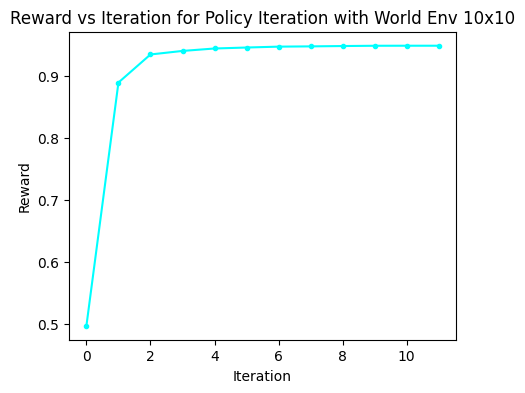

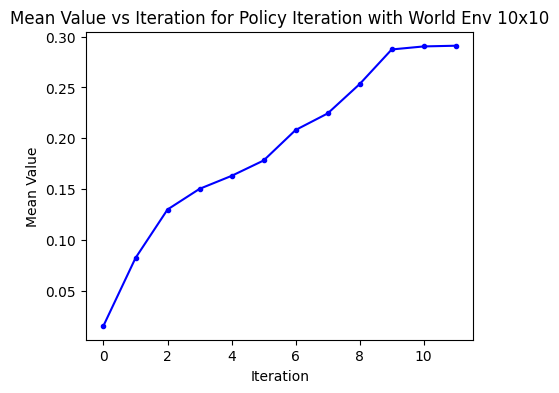

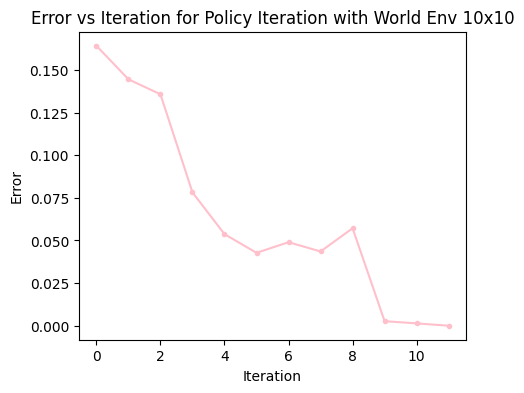

In [211]:
pi = mdp.PolicyIteration(P, R, 0.99, eval_type=1, max_iter=10000)
pi.run()
plot_policy(random_map, pi.policy, f'Policy Iteration_{state_size}')
graph_time("Policy Iteration", pi.run_stats)
graph_reward("Policy Iteration", pi.run_stats)
graph_meanV("Policy Iteration", pi.run_stats)
graph_error("Policy Iteration", pi.run_stats)


In [212]:
print(pi.policy == vi.policy)
print(pi.policy)
print(vi.policy)

False
(3, 3, 3, 0, 3, 3, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 3, 3, 0, 0, 0, 2, 1, 3, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 3, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0)
(3, 3, 3, 0, 3, 3, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 3, 3, 0, 0, 0, 2, 1, 3, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 3, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 2, 2, 1, 1, 3, 3, 3, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0)


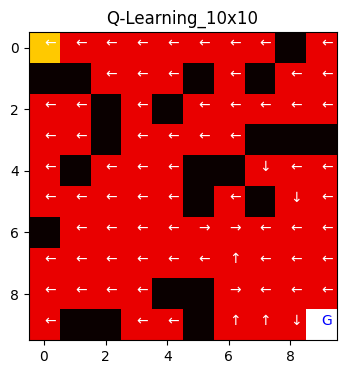

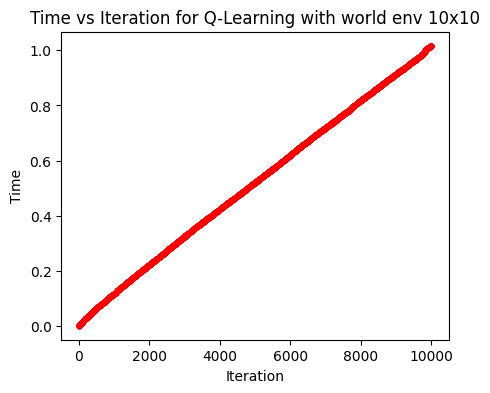

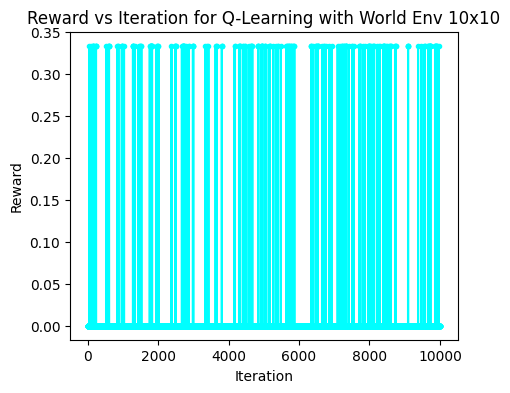

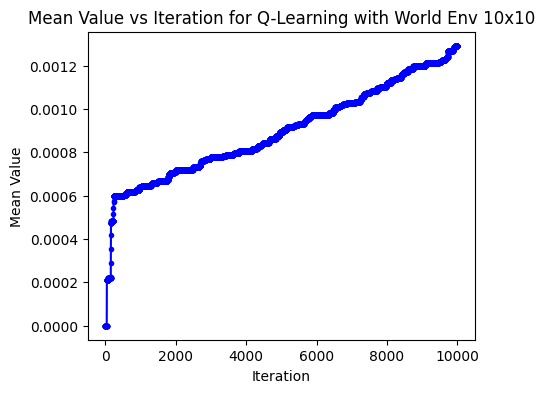

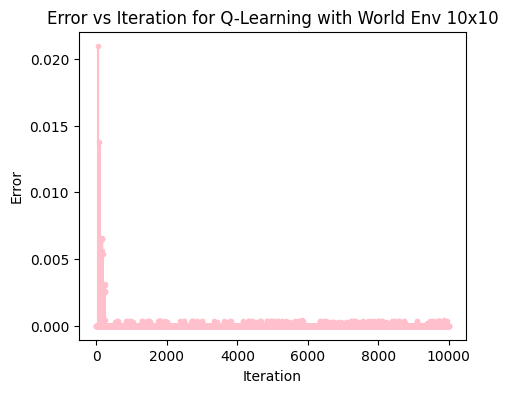

In [213]:
def goal_stats(map):
    stas = []
    for i in range(len(map)):
        for j in range(len(map)):
            if map[i][j] in ('H', 'G'):
                stas.append(i * len(map) + j)
    return stas

def search_new_episode(old_s, action, new_s):
    if new_s in goal_stats(random_map):
        return True
    return False

ql = mdp.QLearning(P, R, 0.99, iter_callback=search_new_episode)
ql.run()

plot_policy(random_map, ql.policy, f'Q-Learning_{state_size}')
graph_time("Q-Learning", ql.run_stats)
graph_reward("Q-Learning", ql.run_stats)
graph_meanV("Q-Learning", ql.run_stats)
graph_error("Q-Learning", ql.run_stats)

# Using different Gamma (discount factor) values

In [214]:
gamma_values = [0.25, 0.45, 0.65, 0.85]
df_vi_all = []

for g in gamma_values:
    vi_new_gamma = mdp.ValueIteration(P, R, gamma=g)
    vi_new_gamma.run()
    df_vi_all.append(pd.DataFrame(vi_new_gamma.run_stats))


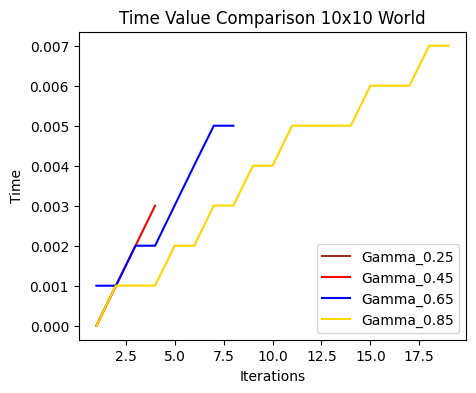

In [111]:

plt.plot(df_vi_all[0]['Iteration'], df_vi_all[0]['Time'], 'brown', label = "Gamma_0.25")
plt.plot(df_vi_all[1]['Iteration'], df_vi_all[1]['Time'], 'red', label = "Gamma_0.45")
plt.plot(df_vi_all[2]['Iteration'], df_vi_all[2]['Time'], 'blue', label = "Gamma_0.65")
plt.plot(df_vi_all[3]['Iteration'], df_vi_all[3]['Time'], 'gold', label = "Gamma_0.85")
plt.title('Time Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Time')   
plt.legend()

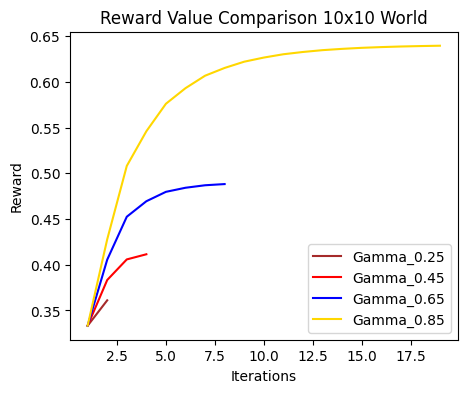

In [112]:
plt.plot(df_vi_all[0]['Iteration'], df_vi_all[0]['Reward'], 'brown', label = "Gamma_0.25")
plt.plot(df_vi_all[1]['Iteration'], df_vi_all[1]['Reward'], 'red', label = "Gamma_0.45")
plt.plot(df_vi_all[2]['Iteration'], df_vi_all[2]['Reward'], 'blue', label = "Gamma_0.65")
plt.plot(df_vi_all[3]['Iteration'], df_vi_all[3]['Reward'], 'gold', label = "Gamma_0.85")
plt.title('Reward Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Reward')   
plt.legend()

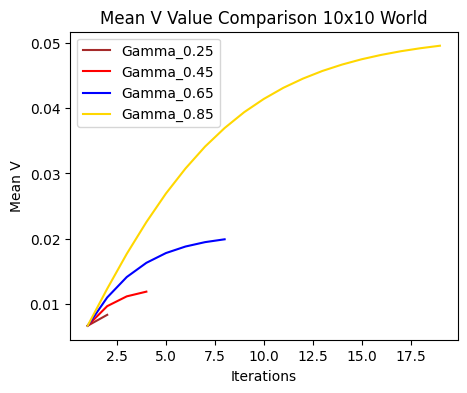

In [113]:
plt.plot(df_vi_all[0]['Iteration'], df_vi_all[0]['Mean V'], 'brown', label = "Gamma_0.25")
plt.plot(df_vi_all[1]['Iteration'], df_vi_all[1]['Mean V'], 'red', label = "Gamma_0.45")
plt.plot(df_vi_all[2]['Iteration'], df_vi_all[2]['Mean V'], 'blue', label = "Gamma_0.65")
plt.plot(df_vi_all[3]['Iteration'], df_vi_all[3]['Mean V'], 'gold', label = "Gamma_0.85")
plt.title('Mean V Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Mean V')   
plt.legend()

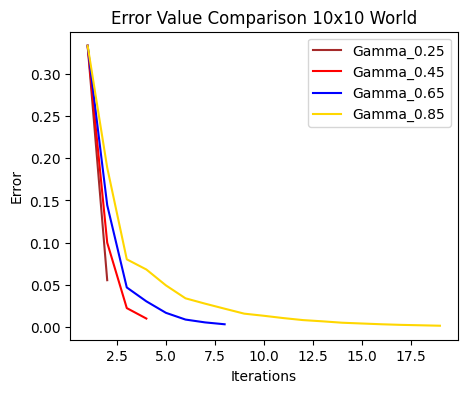

In [114]:
plt.plot(df_vi_all[0]['Iteration'], df_vi_all[0]['Error'], 'brown', label = "Gamma_0.25")
plt.plot(df_vi_all[1]['Iteration'], df_vi_all[1]['Error'], 'red', label = "Gamma_0.45")
plt.plot(df_vi_all[2]['Iteration'], df_vi_all[2]['Error'], 'blue', label = "Gamma_0.65")
plt.plot(df_vi_all[3]['Iteration'], df_vi_all[3]['Error'], 'gold', label = "Gamma_0.85")
plt.title('Error Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Error')   
plt.legend()

In [115]:
gamma_values = [0.25, 0.45, 0.65, 0.85]
df_pi_all = []

for g in gamma_values:
    pi_new_gamma = mdp.PolicyIteration(P, R, gamma=g)
    pi_new_gamma.run()
    df_pi_all.append(pd.DataFrame(pi_new_gamma.run_stats))

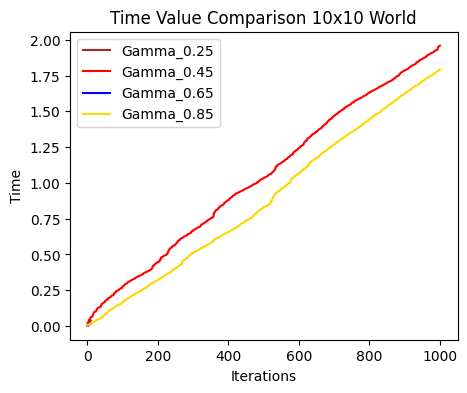

In [116]:
plt.plot(df_pi_all[0]['Iteration'], df_pi_all[0]['Time'], 'brown', label = "Gamma_0.25")
plt.plot(df_pi_all[1]['Iteration'], df_pi_all[1]['Time'], 'red', label = "Gamma_0.45")
plt.plot(df_pi_all[2]['Iteration'], df_pi_all[2]['Time'], 'blue', label = "Gamma_0.65")
plt.plot(df_pi_all[3]['Iteration'], df_pi_all[3]['Time'], 'gold', label = "Gamma_0.85")
plt.title('Time Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Time')   
plt.legend()

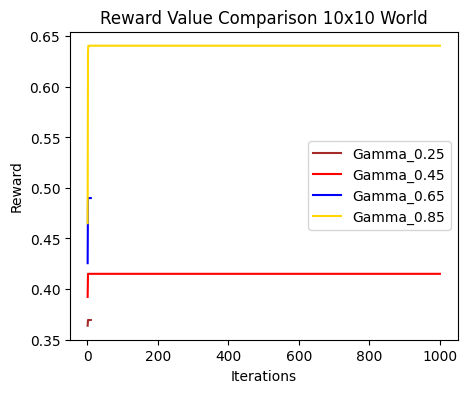

In [117]:
plt.plot(df_pi_all[0]['Iteration'], df_pi_all[0]['Reward'], 'brown', label = "Gamma_0.25")
plt.plot(df_pi_all[1]['Iteration'], df_pi_all[1]['Reward'], 'red', label = "Gamma_0.45")
plt.plot(df_pi_all[2]['Iteration'], df_pi_all[2]['Reward'], 'blue', label = "Gamma_0.65")
plt.plot(df_pi_all[3]['Iteration'], df_pi_all[3]['Reward'], 'gold', label = "Gamma_0.85")
plt.title('Reward Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Reward')   
plt.legend()

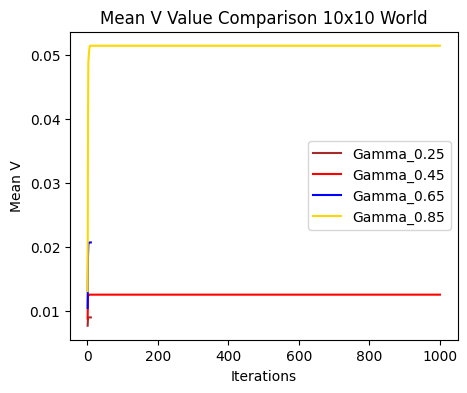

In [118]:
plt.plot(df_pi_all[0]['Iteration'], df_pi_all[0]['Mean V'], 'brown', label = "Gamma_0.25")
plt.plot(df_pi_all[1]['Iteration'], df_pi_all[1]['Mean V'], 'red', label = "Gamma_0.45")
plt.plot(df_pi_all[2]['Iteration'], df_pi_all[2]['Mean V'], 'blue', label = "Gamma_0.65")
plt.plot(df_pi_all[3]['Iteration'], df_pi_all[3]['Mean V'], 'gold', label = "Gamma_0.85")
plt.title('Mean V Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Mean V')   
plt.legend()

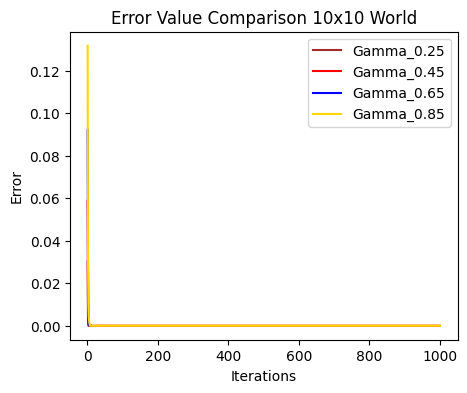

In [119]:
plt.plot(df_pi_all[0]['Iteration'], df_pi_all[0]['Error'], 'brown', label = "Gamma_0.25")
plt.plot(df_pi_all[1]['Iteration'], df_pi_all[1]['Error'], 'red', label = "Gamma_0.45")
plt.plot(df_pi_all[2]['Iteration'], df_pi_all[2]['Error'], 'blue', label = "Gamma_0.65")
plt.plot(df_pi_all[3]['Iteration'], df_pi_all[3]['Error'], 'gold', label = "Gamma_0.85")
plt.title('Error Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Error')   
plt.legend()

In [120]:
gamma_values = [0.25, 0.45, 0.65, 0.85]
df_ql_all = []

for g in gamma_values:
    ql_new_gamma = mdp.QLearning(P, R, gamma=g, iter_callback=search_new_episode)
    ql_new_gamma.run()
    df_ql_all.append(pd.DataFrame(ql_new_gamma.run_stats))

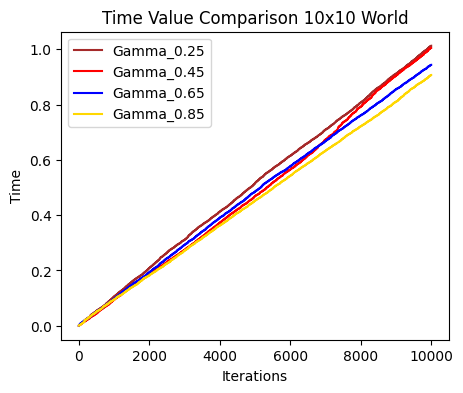

In [121]:
plt.plot(df_ql_all[0]['Iteration'], df_ql_all[0]['Time'], 'brown', label = "Gamma_0.25")
plt.plot(df_ql_all[1]['Iteration'], df_ql_all[1]['Time'], 'red', label = "Gamma_0.45")
plt.plot(df_ql_all[2]['Iteration'], df_ql_all[2]['Time'], 'blue', label = "Gamma_0.65")
plt.plot(df_ql_all[3]['Iteration'], df_ql_all[3]['Time'], 'gold', label = "Gamma_0.85")
plt.title('Time Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Time')   
plt.legend()

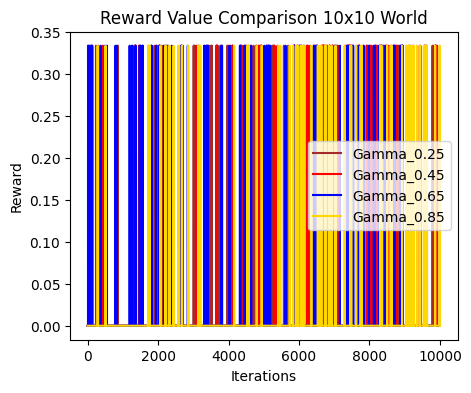

In [122]:
plt.plot(df_ql_all[0]['Iteration'], df_ql_all[0]['Reward'], 'brown', label = "Gamma_0.25")
plt.plot(df_ql_all[1]['Iteration'], df_ql_all[1]['Reward'], 'red', label = "Gamma_0.45")
plt.plot(df_ql_all[2]['Iteration'], df_ql_all[2]['Reward'], 'blue', label = "Gamma_0.65")
plt.plot(df_ql_all[3]['Iteration'], df_ql_all[3]['Reward'], 'gold', label = "Gamma_0.85")
plt.title('Reward Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Reward')   
plt.legend()

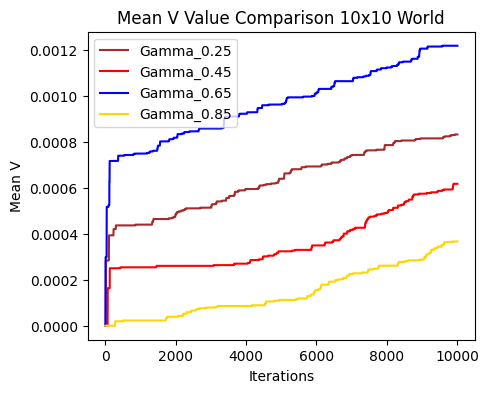

In [123]:
plt.plot(df_ql_all[0]['Iteration'], df_ql_all[0]['Mean V'], 'brown', label = "Gamma_0.25")
plt.plot(df_ql_all[1]['Iteration'], df_ql_all[1]['Mean V'], 'red', label = "Gamma_0.45")
plt.plot(df_ql_all[2]['Iteration'], df_ql_all[2]['Mean V'], 'blue', label = "Gamma_0.65")
plt.plot(df_ql_all[3]['Iteration'], df_ql_all[3]['Mean V'], 'gold', label = "Gamma_0.85")
plt.title('Mean V Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Mean V')   
plt.legend()

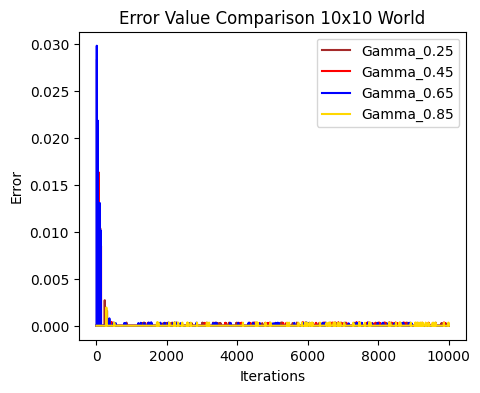

In [124]:
plt.plot(df_ql_all[0]['Iteration'], df_ql_all[0]['Error'], 'brown', label = "Gamma_0.25")
plt.plot(df_ql_all[1]['Iteration'], df_ql_all[1]['Error'], 'red', label = "Gamma_0.45")
plt.plot(df_ql_all[2]['Iteration'], df_ql_all[2]['Error'], 'blue', label = "Gamma_0.65")
plt.plot(df_ql_all[3]['Iteration'], df_ql_all[3]['Error'], 'gold', label = "Gamma_0.85")
plt.title('Error Value Comparison 10x10 World')
plt.xlabel('Iterations')   
plt.ylabel('Error')   
plt.legend()